In [317]:
using CSV
using DataFrames
using Statistics

using Plots
using Plots.PlotMeasures
using StatsPlots, KernelDensity

using NCBITaxonomy

In [646]:
include("src/entropy.jl")

macro Name(arg)
    string(arg)
end


"x"

In [24]:
for file in readdir("data")
    if endswith(file, ".tsv")

        df = CSV.read("data/$file", DataFrame, delim="\t", header=1)
        df[!, [:fxity, :aver_rmsd]] = round.(df[:,[:fxity, :aver_rmsd]], digits = 2)
        df = dropmissing(df)


        println("fxity vs nclusts: ", round(cor(df.fxity, df.nclusts), digits = 2),
        ";      fxity vs aver_rmsd: ", round(cor(df.fxity, df.aver_rmsd), digits = 2),
        ";      nclusts vs nfrags: ", round(cor(df.nclusts, df.nfrags), digits = 2),
        ";      nclusts vs aver_rmsd: ", round(cor(df.nclusts, df.aver_rmsd), digits = 2 )
        )


        p1 = histogram(df.fxity, bins=25,    xlabel="fxity", ylabel="Frequency", labels="")
        p2 = histogram(df.nclusts, bins=25,    xlabel="nclusts", ylabel="Frequency", labels="")
        p3 = histogram(df.aver_rmsd, bins=25,   xlabel="aver_rmsd", ylabel="Frequency", labels="")
        p4 = histogram(df.nfrags, bins=25,    xlabel="nfrags", ylabel="Frequency", labels="")

        p5 = scatter(df.fxity, df.nclusts,  xlabel="fxity", ylabel="nclusts", markershape=:circle, markersize = 3, labels="")
        p6 = scatter(df.fxity, df.aver_rmsd,  xlabel="fxity", ylabel="aver_rmsd", markershape=:circle, markersize = 3,labels="")
        p7 = scatter(df.nclusts, df.nfrags,  xlabel="nclusts", ylabel="nfrags", markershape=:circle, markersize = 3, labels="")
        p8 = scatter(df.nclusts, df.aver_rmsd,  xlabel="nclusts", ylabel="aver_rmsd", markershape=:circle, markersize = 3, labels="")



        plot(p1, p2, p3, p4, p5, p6, p7, p8, layout=(2, 4), margins = 5mm, dpi=300, xtickfontsize=6, ytickfontsize=6)
        plot!(size=(900,600))
        savefig("data/$(split(file,".")[1]).png")
    end
end



fxity vs nclusts: -0.1;      fxity vs aver_rmsd: 0.55;      nclusts vs nfrags: 0.91;      nclusts vs aver_rmsd: 0.37
fxity vs nclusts: -0.13;      fxity vs aver_rmsd: 0.51;      nclusts vs nfrags: 0.87;      nclusts vs aver_rmsd: 0.43
fxity vs nclusts: -0.08;      fxity vs aver_rmsd: 0.49;      nclusts vs nfrags: 0.87;      nclusts vs aver_rmsd: 0.38
fxity vs nclusts: -0.03;      fxity vs aver_rmsd: 0.55;      nclusts vs nfrags: 0.9;      nclusts vs aver_rmsd: 0.31
fxity vs nclusts: NaN;      fxity vs aver_rmsd: NaN;      nclusts vs nfrags: 1.0;      nclusts vs aver_rmsd: NaN


In [102]:
taxondata = CSV.read("data/astral.id", DataFrame, header=1)

ids = []
lineages = []

for (id, taxid) in zip(taxondata.id, taxondata.taxid)
    try
        push!(lineages, lineage(taxon(taxid)))
        push!(ids, id) 
    catch
        println(id)
    end
end

domains = [taxid[3].name for taxid=lineages]
domaindata = DataFrame(id=ids, domain=domains)
df = dropmissing(domaindata)
e = "Eukaryota"
b = "Bacteria" 
a = "Archaea" 

In [475]:
entropies = structure2fs3di("../scop40NR")
select!(entropies, Not([:coords]));
transform!(entropies, :id => ByRow(s -> first(split(s, "."))) => :id)
print()


In [630]:
entropies[!, :H_aa] = shannon.(entropies.seqaa) ./ length.(entropies.seqaa) 
entropies[!, :H_3Di] = shannon.(entropies.seq3di) ./ length.(entropies.seqaa) 
entropies[!, :H_aa3] = shannon.(entropies.seqaa,3) ./ length.(entropies.seqaa) 
entropies[!, :H_3Di3] = shannon.(entropies.seq3di,3) ./ length.(entropies.seqaa) 
entropies[!, :H_aa4] = shannon.(entropies.seqaa,4) ./ length.(entropies.seqaa) 
entropies[!, :H_3Di4] = shannon.(entropies.seq3di,4) ./ length.(entropies.seqaa) 
entropies[!, :H_aa5] = shannon.(entropies.seqaa,5) #./ length.(entropies.seqaa) 
entropies[!, :H_3Di5] = shannon.(entropies.seq3di,5) #./ length.(entropies.seqaa) 
print()

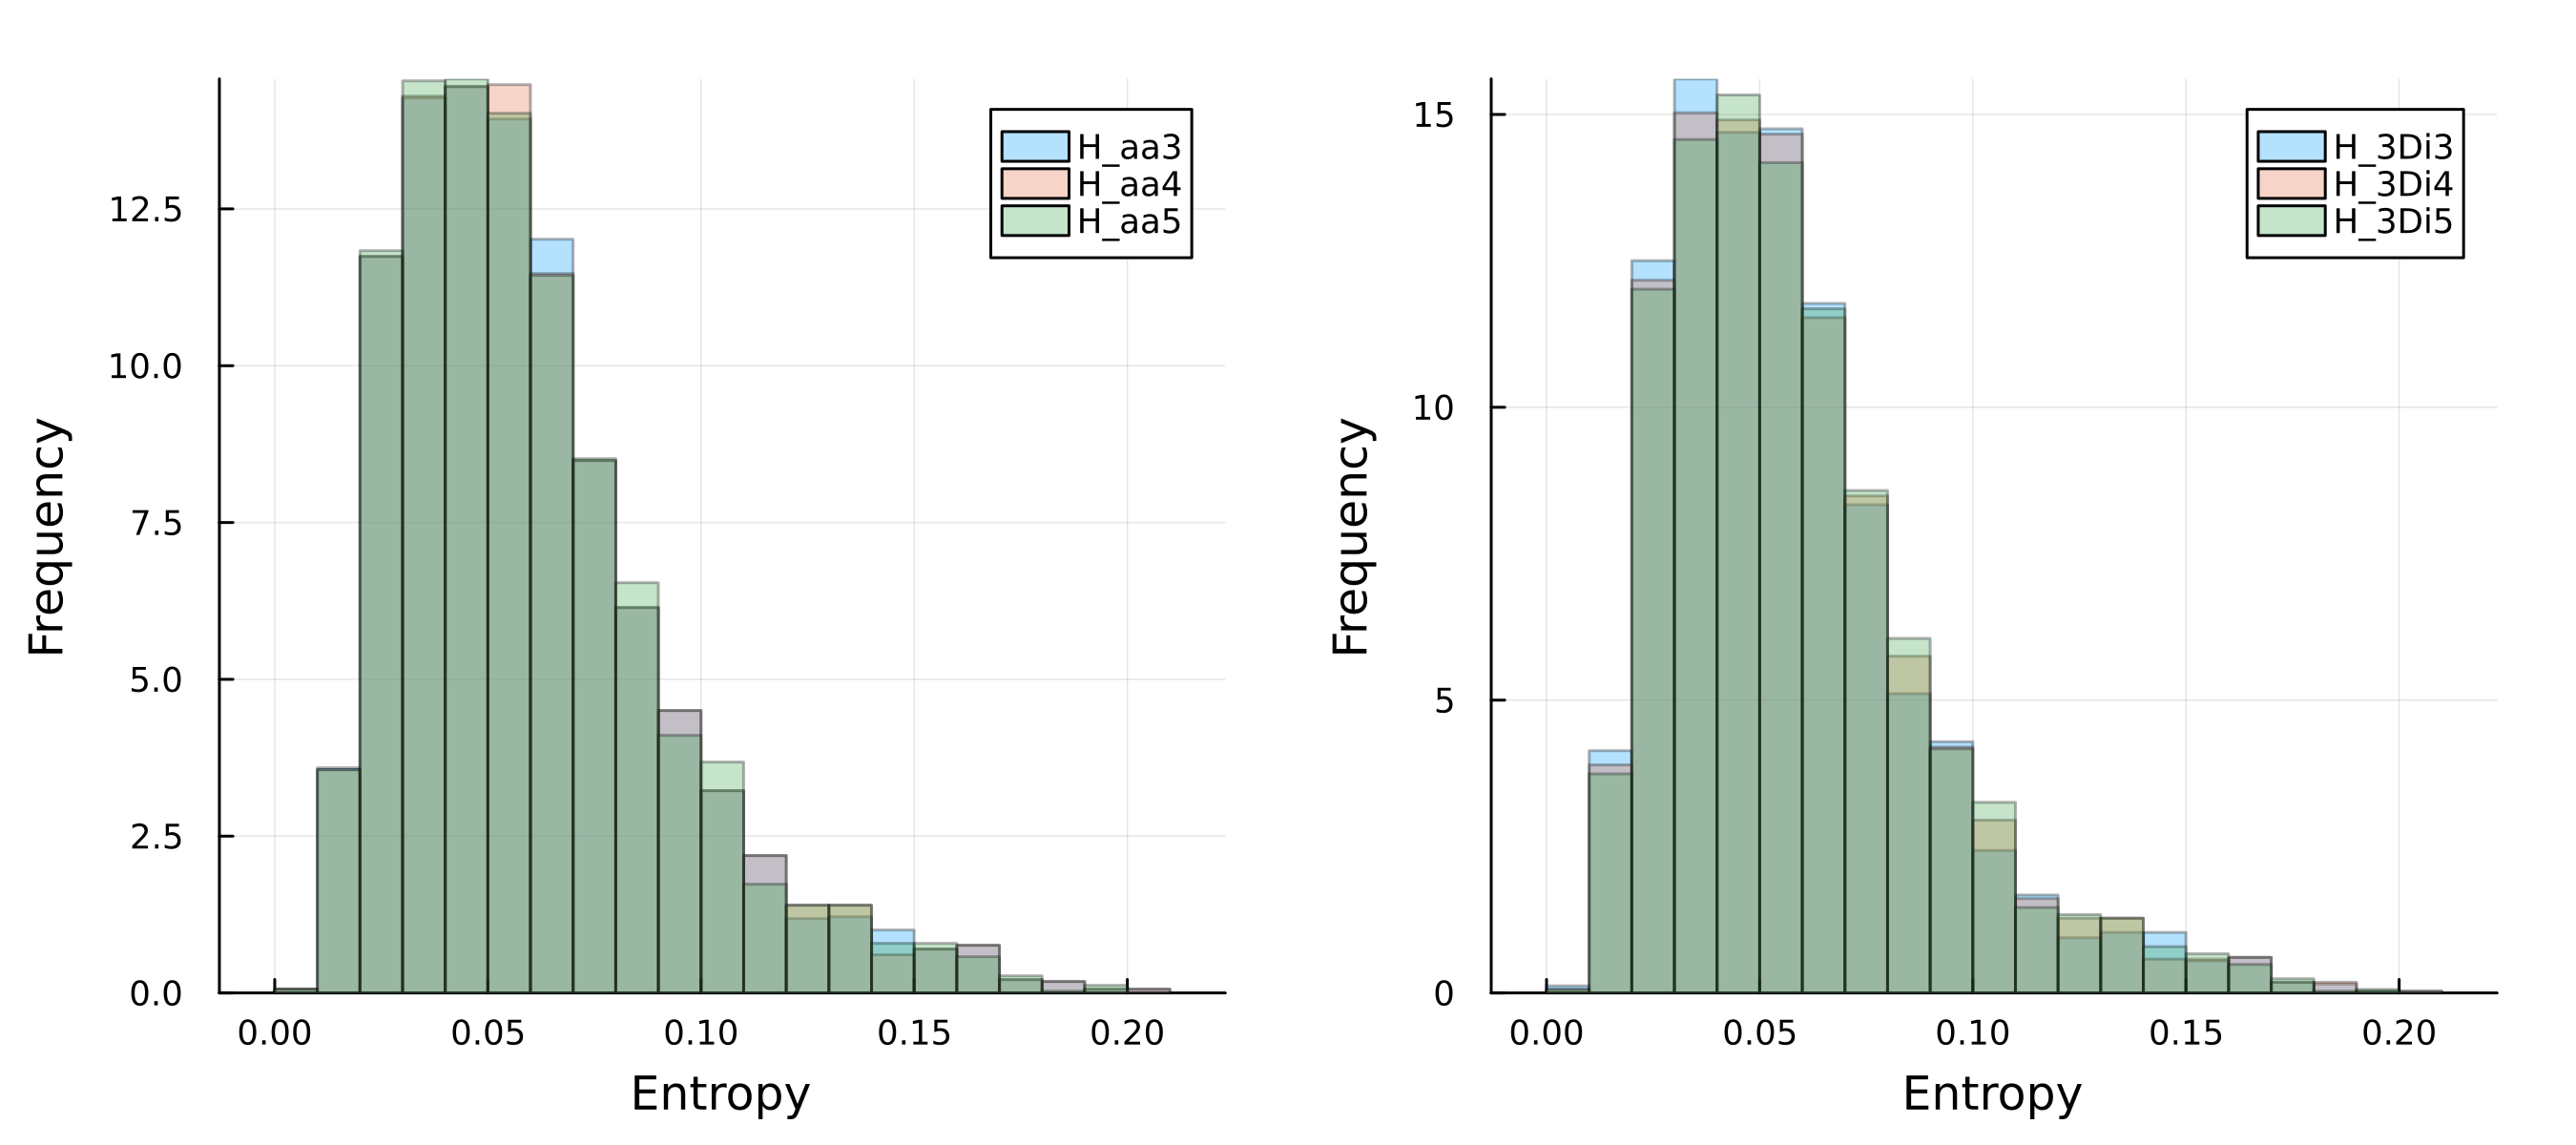

In [578]:
h1 = histogram([entropies[:, Haa] for Haa ∈ ("H_aa3", "H_aa4", "H_aa5")], bins=25, xlabel="Entropy",  ylabel="Frequency", normalize=:pdf, labels=["H_aa3" "H_aa4" "H_aa5"], alpha=0.3)
h2 = histogram([entropies[:, Haa] for Haa ∈ ("H_3Di3", "H_3Di4", "H_3Di5")], bins=25, xlabel="Entropy", ylabel="Frequency", normalize=:pdf, labels=["H_3Di3" "H_3Di4" "H_3Di5"], alpha=0.3)
plot(h1, h2, layout=(1, 2), size=(900,400), dpi=300, margins = 5mm, )#xlimit = (2, 10), ytickfontsize=6, xtickfontsize=6)

In [ ]:
fxdata = CSV.read("data/scop40_fs3_rmsd05.tsv", DataFrame, delim="\t", header=1)
df = innerjoin(fxdata, taxondata, domaindata, entropies, on=:id)
df = dropmissing(df)
df[!,:plen] = length.(df.seqaa)
df = df[!, [:ndx, :id, :scop, :domain, :taxid, :fxity, :nclusts, :aver_rmsd, :nfrags, :plen, :H_aa, :H_aa3, :H_aa4, :H_aa5, :H_3Di, :H_3Di3, :H_3Di4, :H_3Di5, :seqaa, :seq3di]] 
size(df)


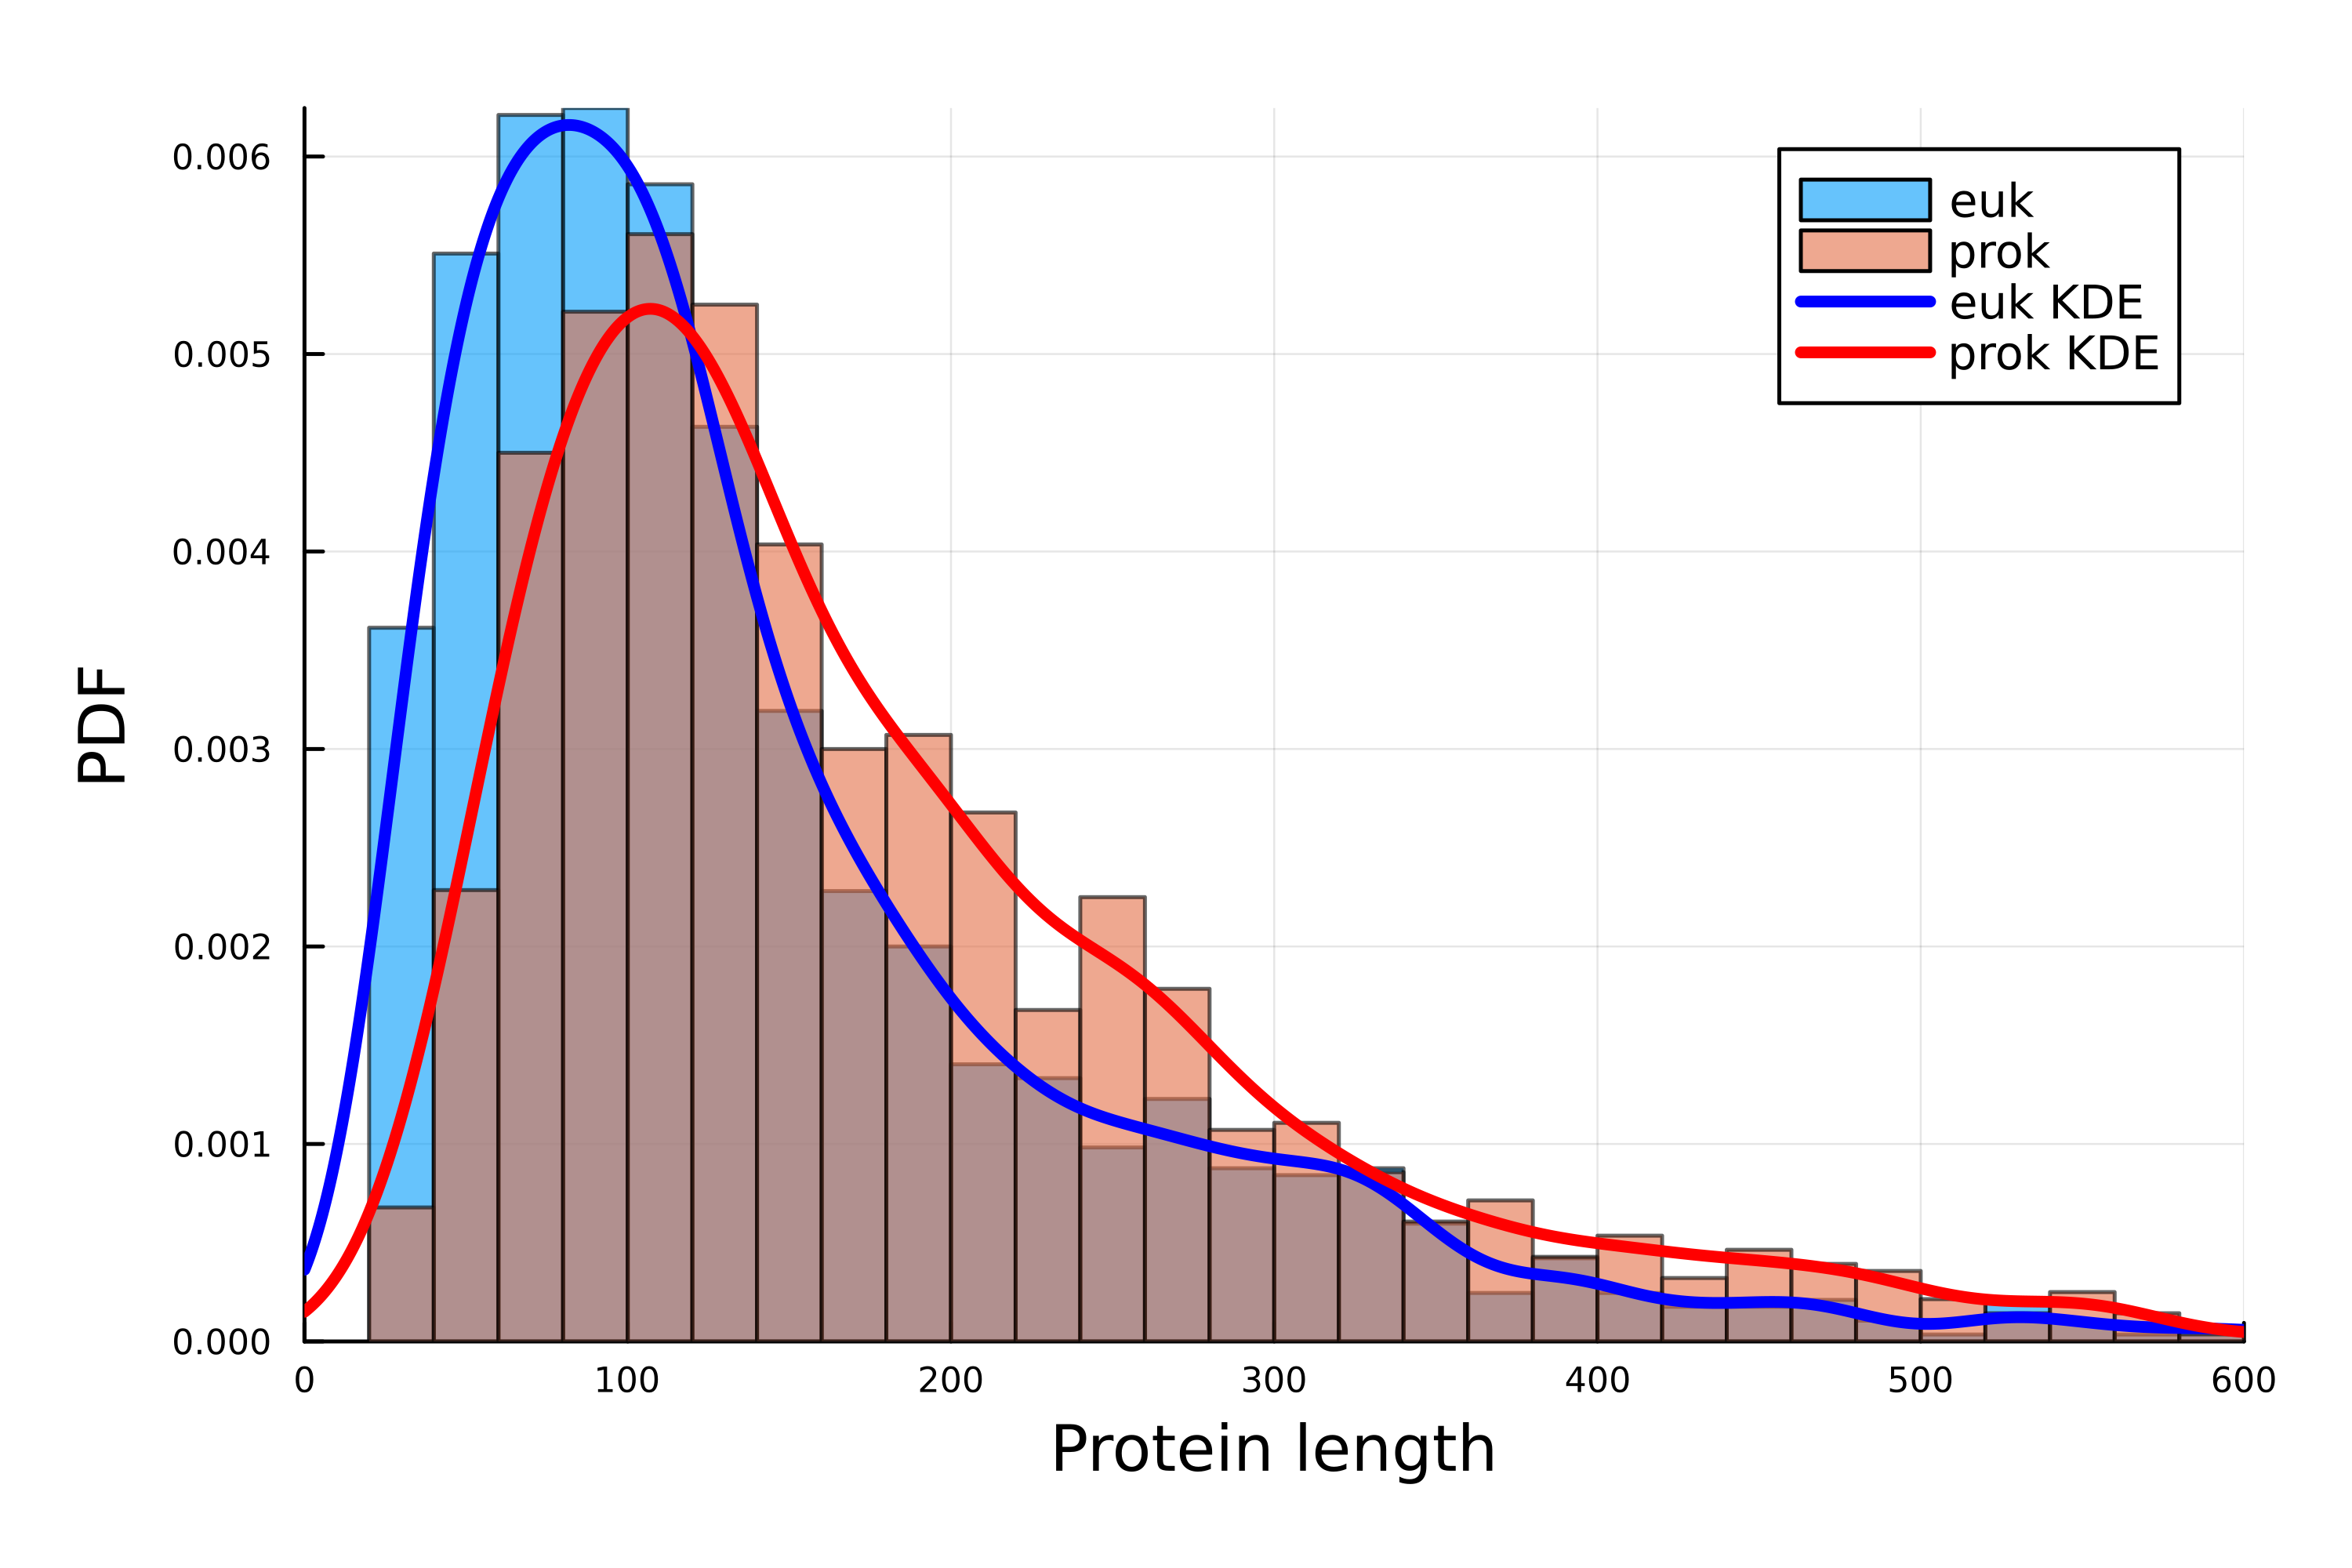

In [637]:
#df = df[(df.plen .> 100) .& (df.plen .< 200) ,:]

elen = df[(df.domain .== e),:].plen
blen = df[(df.domain .== b),:].plen
xlim= (0,600)

h1 = histogram(elen, bins=50, label="euk", alpha=0.6, normalize=:pdf,)
h1 = histogram!(blen, bins=50,  label="prok", alpha=0.6, normalize=:pdf,
    xlabel="Protein length", ylabel="PDF", legend=:topright, xlimit=xlim)
h1 = plot!(kde(elen).x, kde(elen).density, linewidth=3, label="euk KDE", color=:blue)
h1 = plot!(kde(blen).x, kde(blen).density, linewidth=3, label="prok KDE", color=:red)


plot(h1, margins = 5mm, dpi=500, size=(600,400), xtickfontsize=6, ytickfontsize=6)

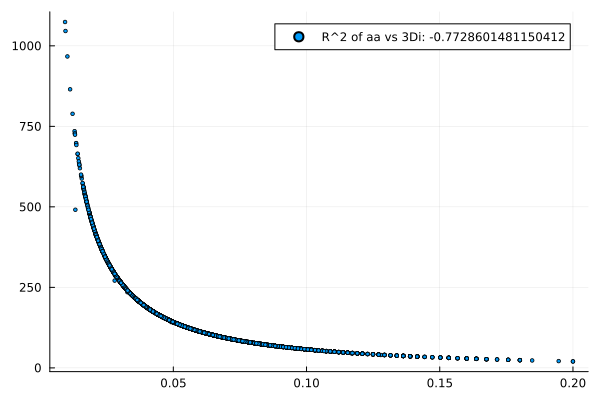

In [648]:
H_Eaa4 = df[df.domain .== e,:].H_aa4
H_Eaa5 = df[df.domain .== e,:].H_aa5
H_B3Di4 = df[df.domain .== b,:].H_3Di4
H_B3Di5 = df[df.domain .== b,:].H_3Di5

x = df.H_aa4
y = df.plen
scatter(x, y, label="R^2 of aa vs 3Di: $(cor(x, y))", markershape=:circle, markersize = 2)


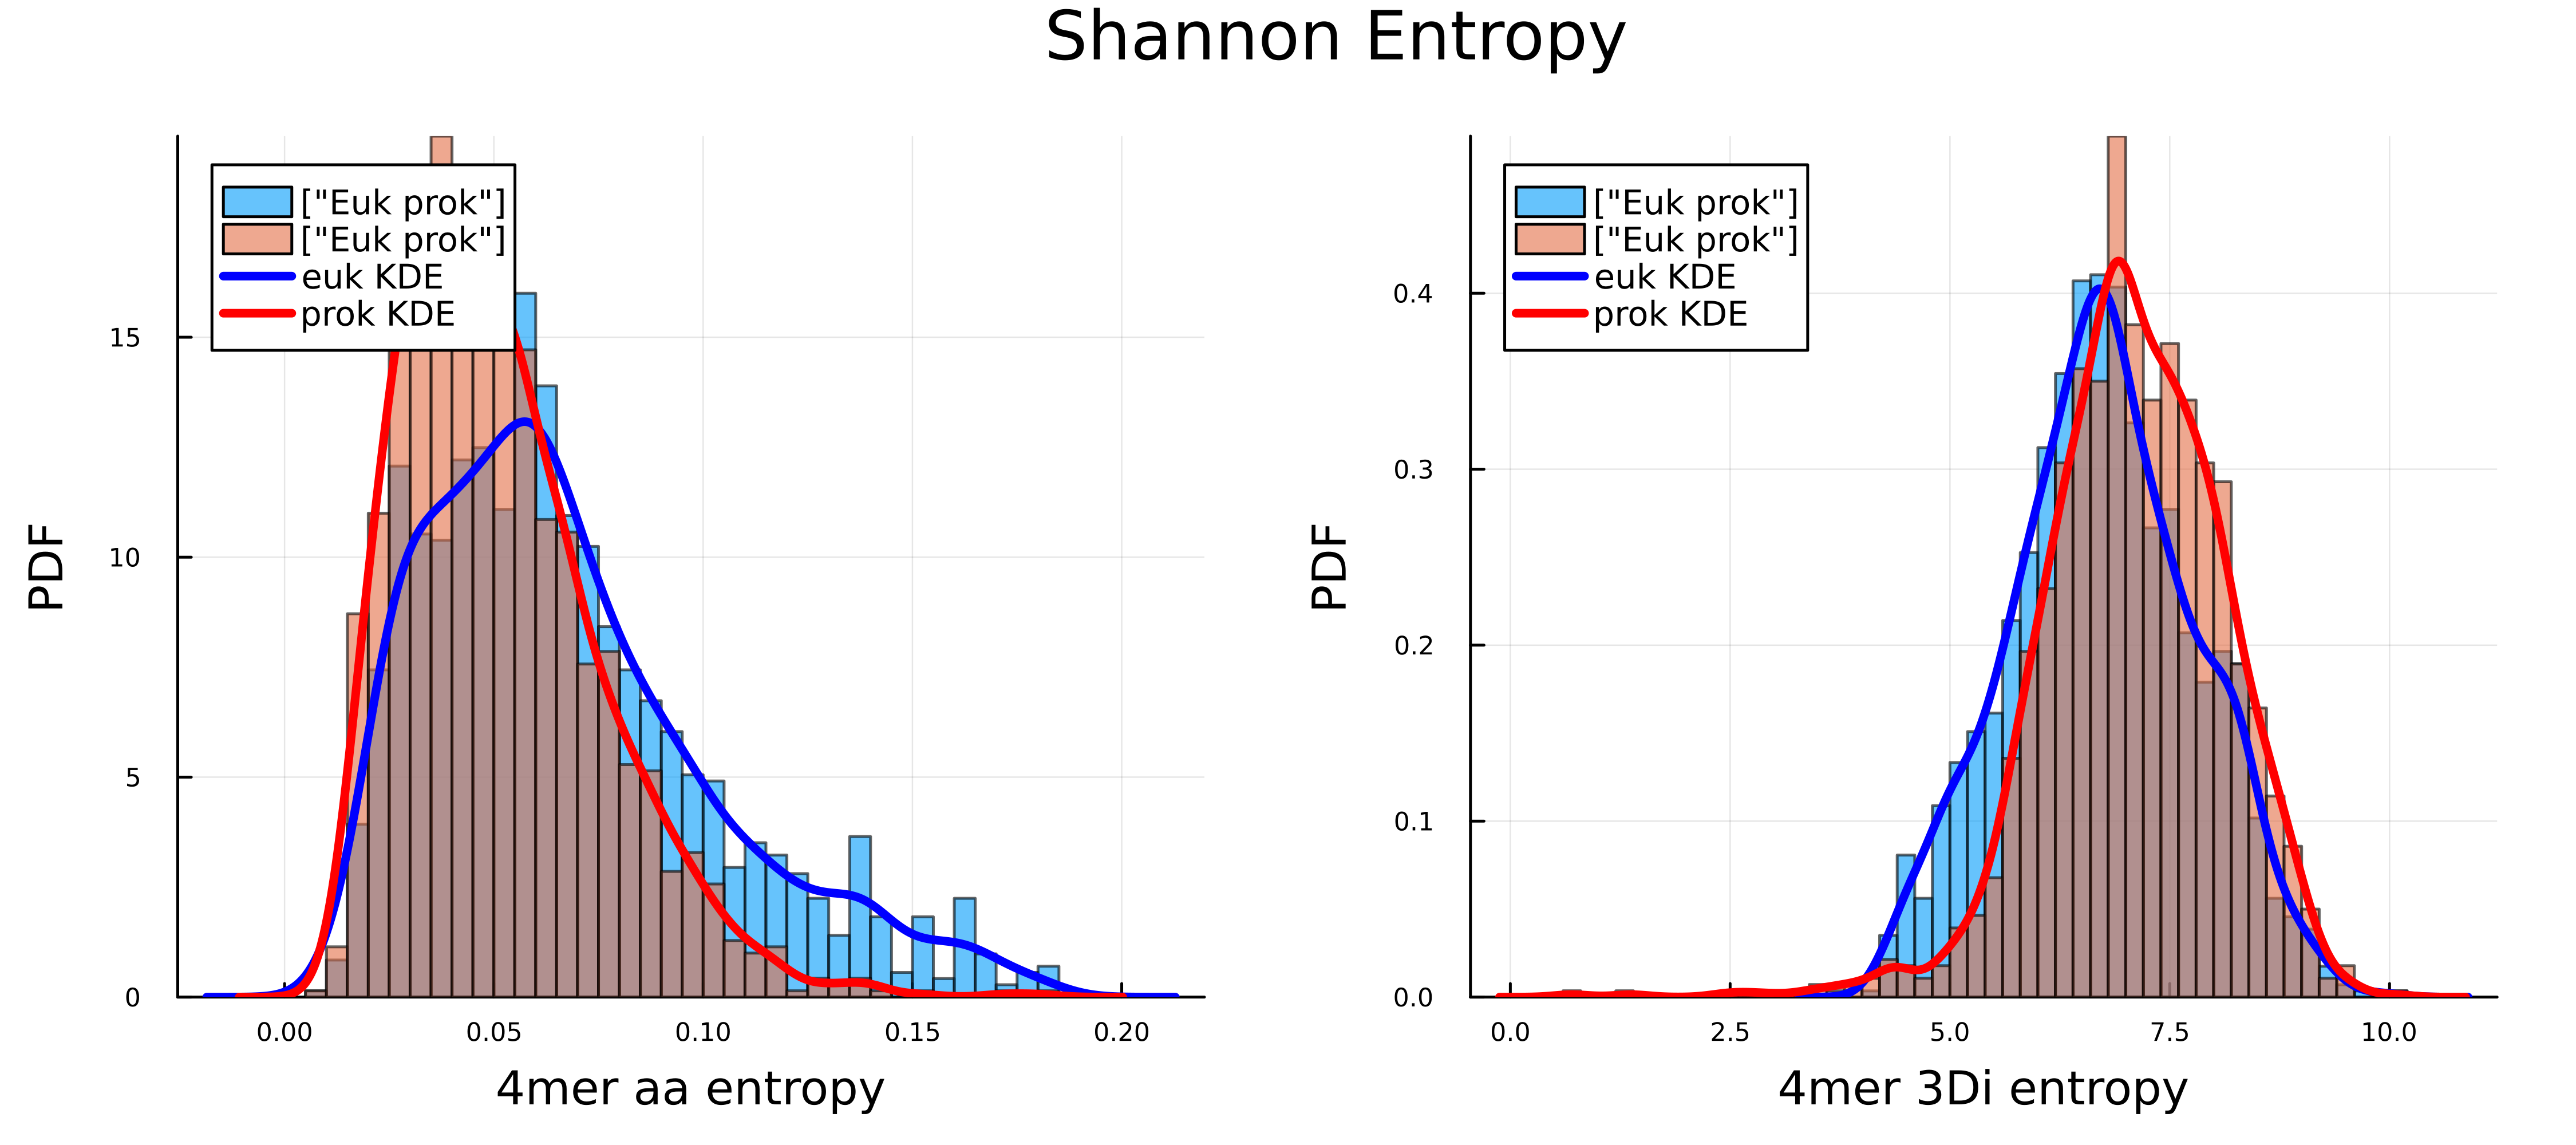

In [649]:

xlim = (0,12)
h1 = histogram([H_Eaa4, H_B3Di4], bins=50,  labels=["Euk prok"], alpha=0.6, normalize=:pdf,
    xlabel="4mer aa entropy", ylabel="PDF", legend=:topleft)
h1 = plot!(kde(H_Eaa4).x, kde(H_Eaa4).density, linewidth=3, label="euk KDE", color=:blue)
h1 = plot!(kde(H_B3Di4).x, kde(H_B3Di4).density, linewidth=3, label="prok KDE", color=:red)
    

h2 = histogram([H_Eaa5, H_B3Di5], bins=50,  labels=["Euk prok"], alpha=0.6, normalize=:pdf,
    xlabel="4mer 3Di entropy", ylabel="PDF", legends=:topleft)
h2 = plot!(kde(H_Eaa5).x, kde(H_Eaa5).density, linewidth=3, label="euk KDE", color=:blue)
h2 = plot!(kde(H_B3Di5).x, kde(H_B3Di5).density, linewidth=3, label="prok KDE", color=:red)

plot(h1, h2, layout=(1,2), margins = 5mm, dpi=500, size=(900,400), 
    plot_title = "Shannon Entropy", xtickfontsize=6, ytickfontsize=6)

In [252]:
println("foldexity ", mean(df[df.domain .== e,:].fxity))
println("foldexity ", mean(df[df.domain .== b,:].fxity))
println("foldexity ", mean(df[df.domain .== a,:].fxity))
println("foldexity ", median(df[df.domain .== e,:].fxity))
println("foldexity ", median(df[df.domain .== b,:].fxity))
println("foldexity ", median(df[df.domain .== a,:].fxity))
println()
println("average RMSD: ",mean(df[df.domain .== e,:].aver_rmsd))
println("average RMSD: ",mean(df[df.domain .== b,:].aver_rmsd))
println("average RMSD: ",mean(df[df.domain .== a,:].aver_rmsd))
println("average RMSD: ",median(df[df.domain .== e,:].aver_rmsd))
println("average RMSD: ",median(df[df.domain .== b,:].aver_rmsd))
println("average RMSD: ",median(df[df.domain .== a,:].aver_rmsd))

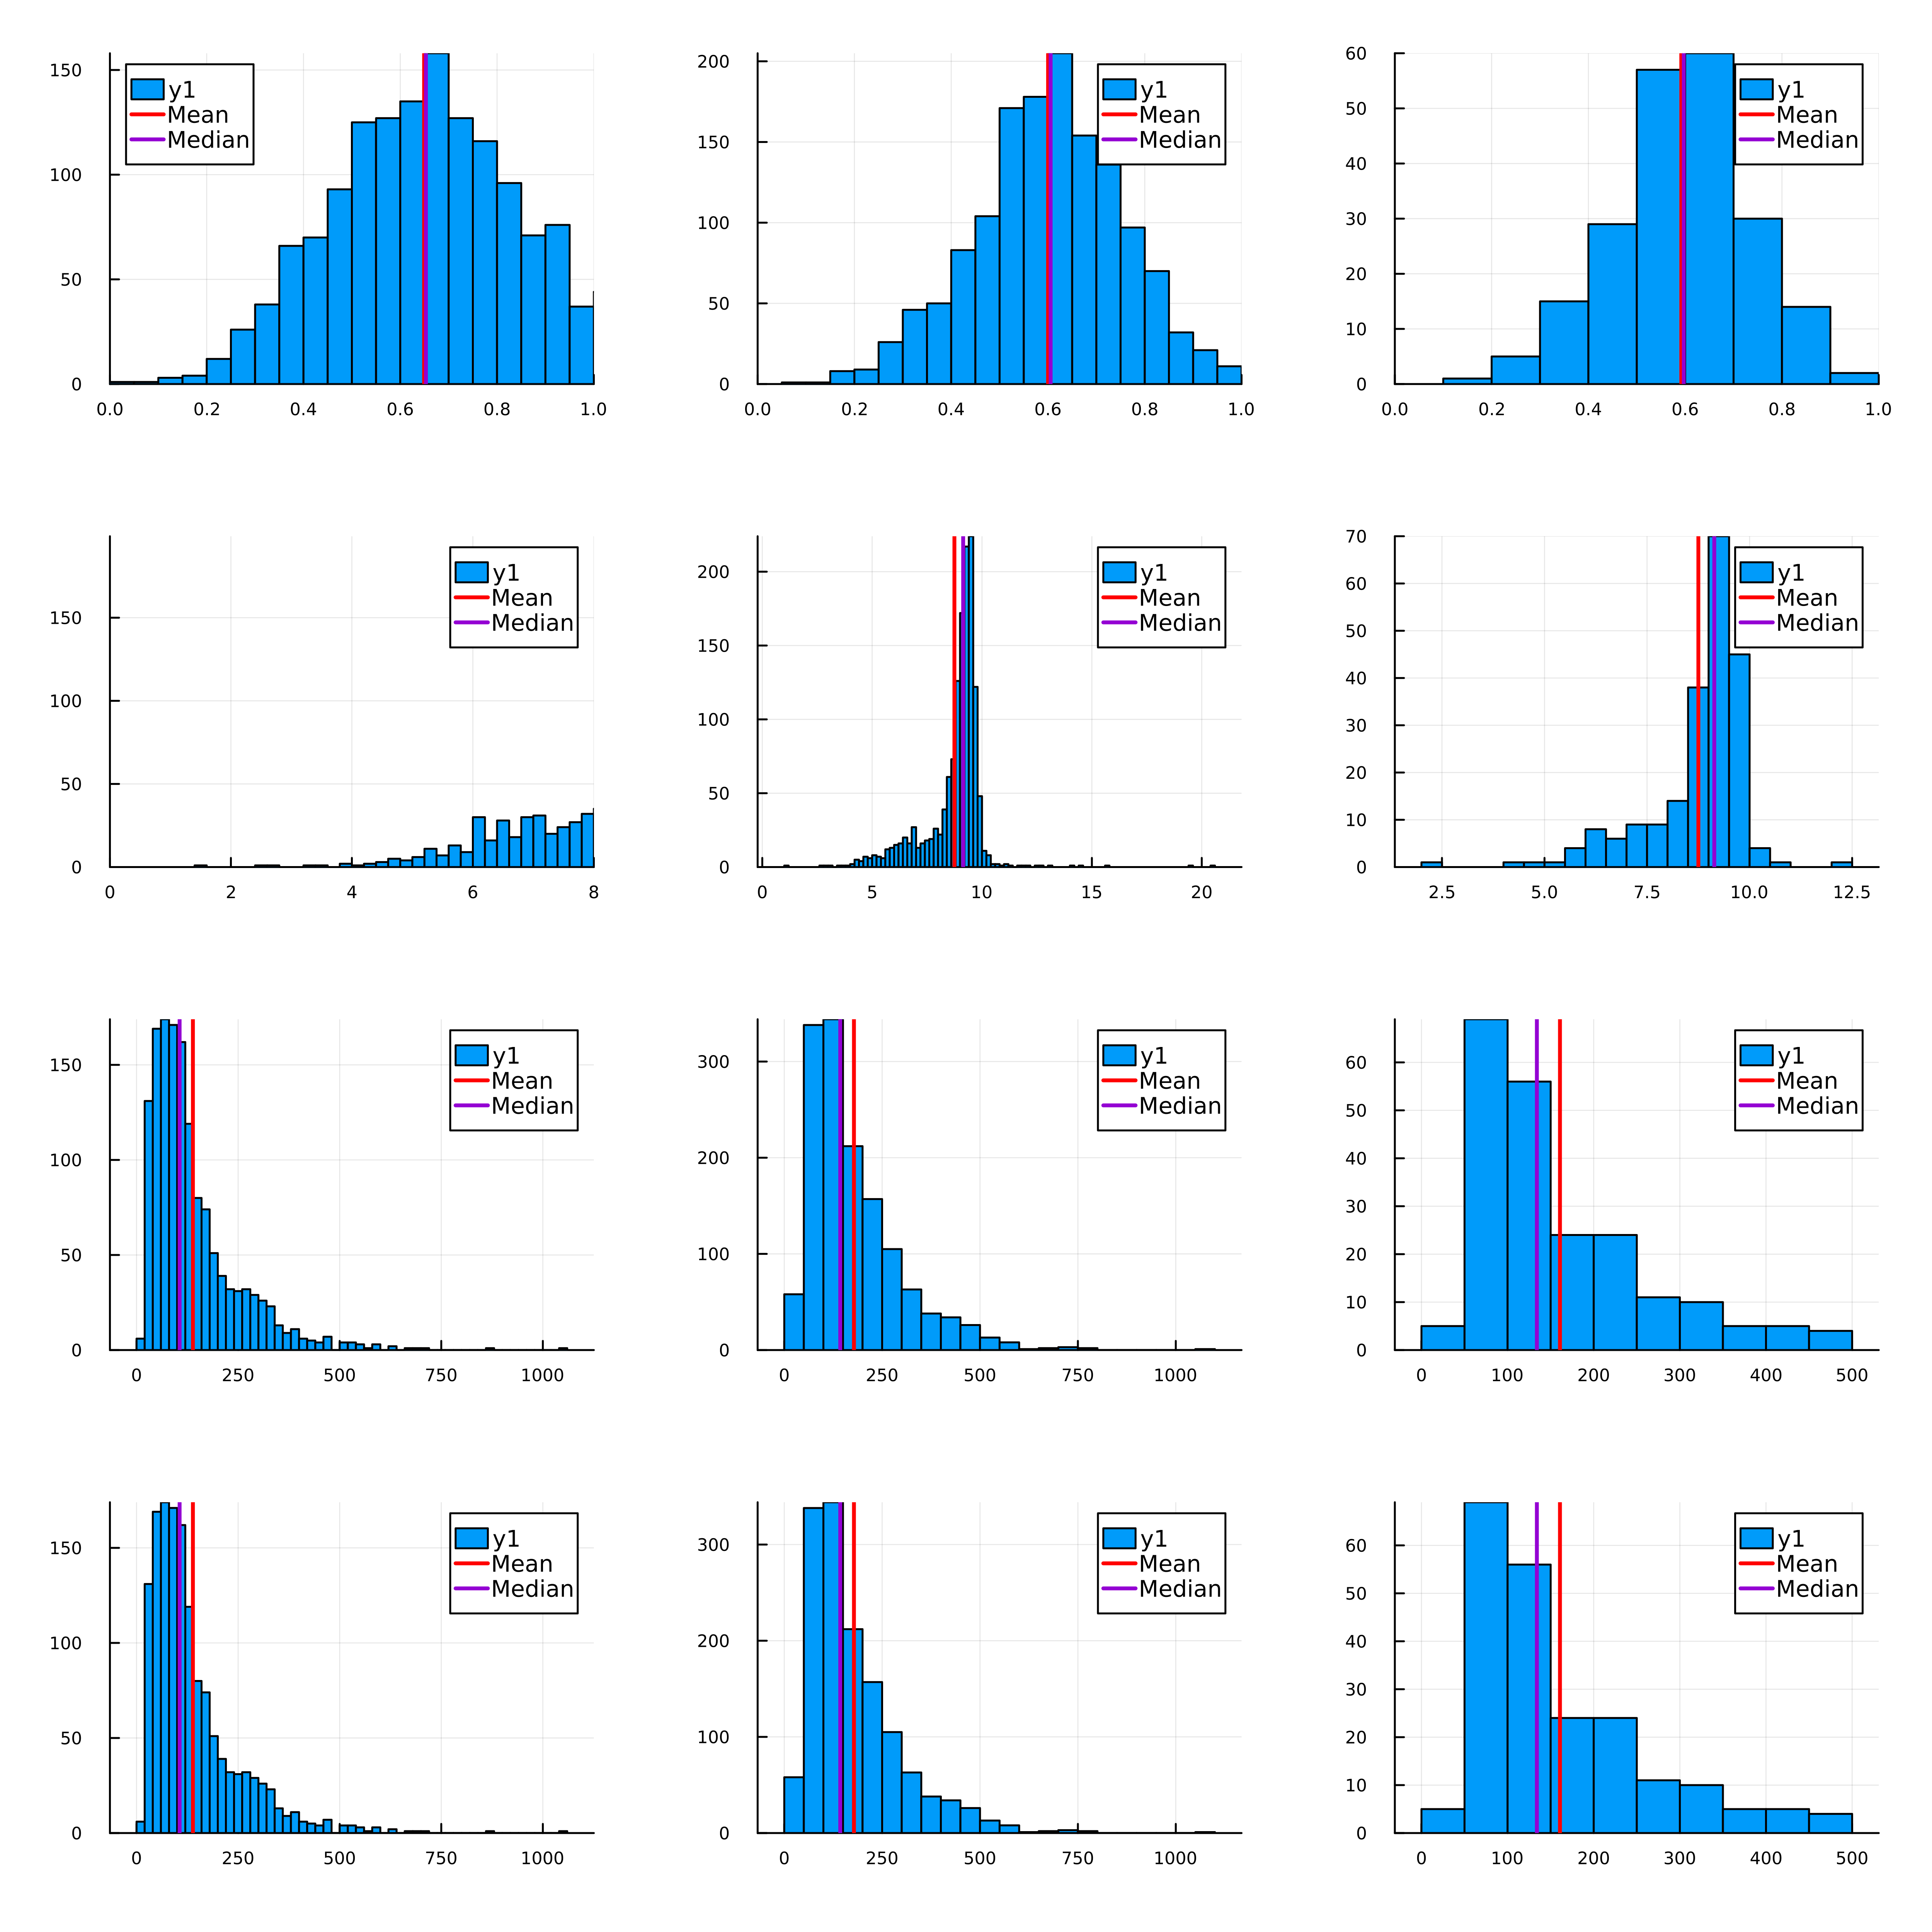

In [246]:
p11 = histogram(df[df.domain .== e,:].fxity, xlimits=(0,1))
p21 = histogram(df[df.domain .== b,:].fxity, xlimits=(0,1))
p31 = histogram(df[df.domain .== a,:].fxity, xlimits=(0,1))
vline!(p11, [mean(df[df.domain .== e,:].fxity)], lw=2, color="red", label="Mean")
vline!(p21, [mean(df[df.domain .== b,:].fxity)], lw=2, color="red", label="Mean")
vline!(p31, [mean(df[df.domain .== a,:].fxity)], lw=2, color="red", label="Mean")
vline!(p11, [median(df[df.domain .== e,:].fxity)], lw=2, color="dark violet", label="Median")
vline!(p21, [median(df[df.domain .== b,:].fxity)], lw=2, color="dark violet", label="Median")
vline!(p31, [median(df[df.domain .== a,:].fxity)], lw=2, color="dark violet", label="Median")

p12 = histogram(df[df.domain .== e,:].aver_rmsd, xlimits = (0,8))
p22 = histogram(df[df.domain .== b,:].aver_rmsd)
p32 = histogram(df[df.domain .== a,:].aver_rmsd)
vline!(p12, [mean(df[df.domain .== e,:].aver_rmsd)], lw=2, color="red", label="Mean")
vline!(p22, [mean(df[df.domain .== b,:].aver_rmsd)], lw=2, color="red", label="Mean")
vline!(p32, [mean(df[df.domain .== a,:].aver_rmsd)], lw=2, color="red", label="Mean")
vline!(p12, [median(df[df.domain .== e,:].aver_rmsd)], lw=2, color="dark violet", label="Median")
vline!(p22, [median(df[df.domain .== b,:].aver_rmsd)], lw=2, color="dark violet", label="Median")
vline!(p32, [median(df[df.domain .== a,:].aver_rmsd)], lw=2, color="dark violet", label="Median")

p13 = histogram(df[df.domain .== e,:].nfrags)
p23 = histogram(df[df.domain .== b,:].nfrags)
p33 = histogram(df[df.domain .== a,:].nfrags)
vline!(p13, [mean(df[df.domain .== e,:].nfrags)], lw=2, color="red", label="Mean")
vline!(p23, [mean(df[df.domain .== b,:].nfrags)], lw=2, color="red", label="Mean")
vline!(p33, [mean(df[df.domain .== a,:].nfrags)], lw=2, color="red", label="Mean")
vline!(p13, [median(df[df.domain .== e,:].nfrags)], lw=2, color="dark violet", label="Median")
vline!(p23, [median(df[df.domain .== b,:].nfrags)], lw=2, color="dark violet", label="Median")
vline!(p33, [median(df[df.domain .== a,:].nfrags)], lw=2, color="dark violet", label="Median")

p14 = histogram(df[df.domain .== e,:].nfrags)
p24 = histogram(df[df.domain .== b,:].nfrags)
p34 = histogram(df[df.domain .== a,:].nfrags)
vline!(p14, [mean(df[df.domain .== e,:].nfrags)], lw=2, color="red", label="Mean")
vline!(p24, [mean(df[df.domain .== b,:].nfrags)], lw=2, color="red", label="Mean")
vline!(p34, [mean(df[df.domain .== a,:].nfrags)], lw=2, color="red", label="Mean")
vline!(p14, [median(df[df.domain .== e,:].nfrags)], lw=2, color="dark violet", label="Median")
vline!(p24, [median(df[df.domain .== b,:].nfrags)], lw=2, color="dark violet", label="Median")
vline!(p34, [median(df[df.domain .== a,:].nfrags)], lw=2, color="dark violet", label="Median")



plot(p11, p21, p31, p12, p22, p32, p13, p23, p33, p14, p24, p34, layout=(4, 3), margins = 5mm, dpi=500, xtickfontsize=6, ytickfontsize=6)
plot!(size=(1000,1000))

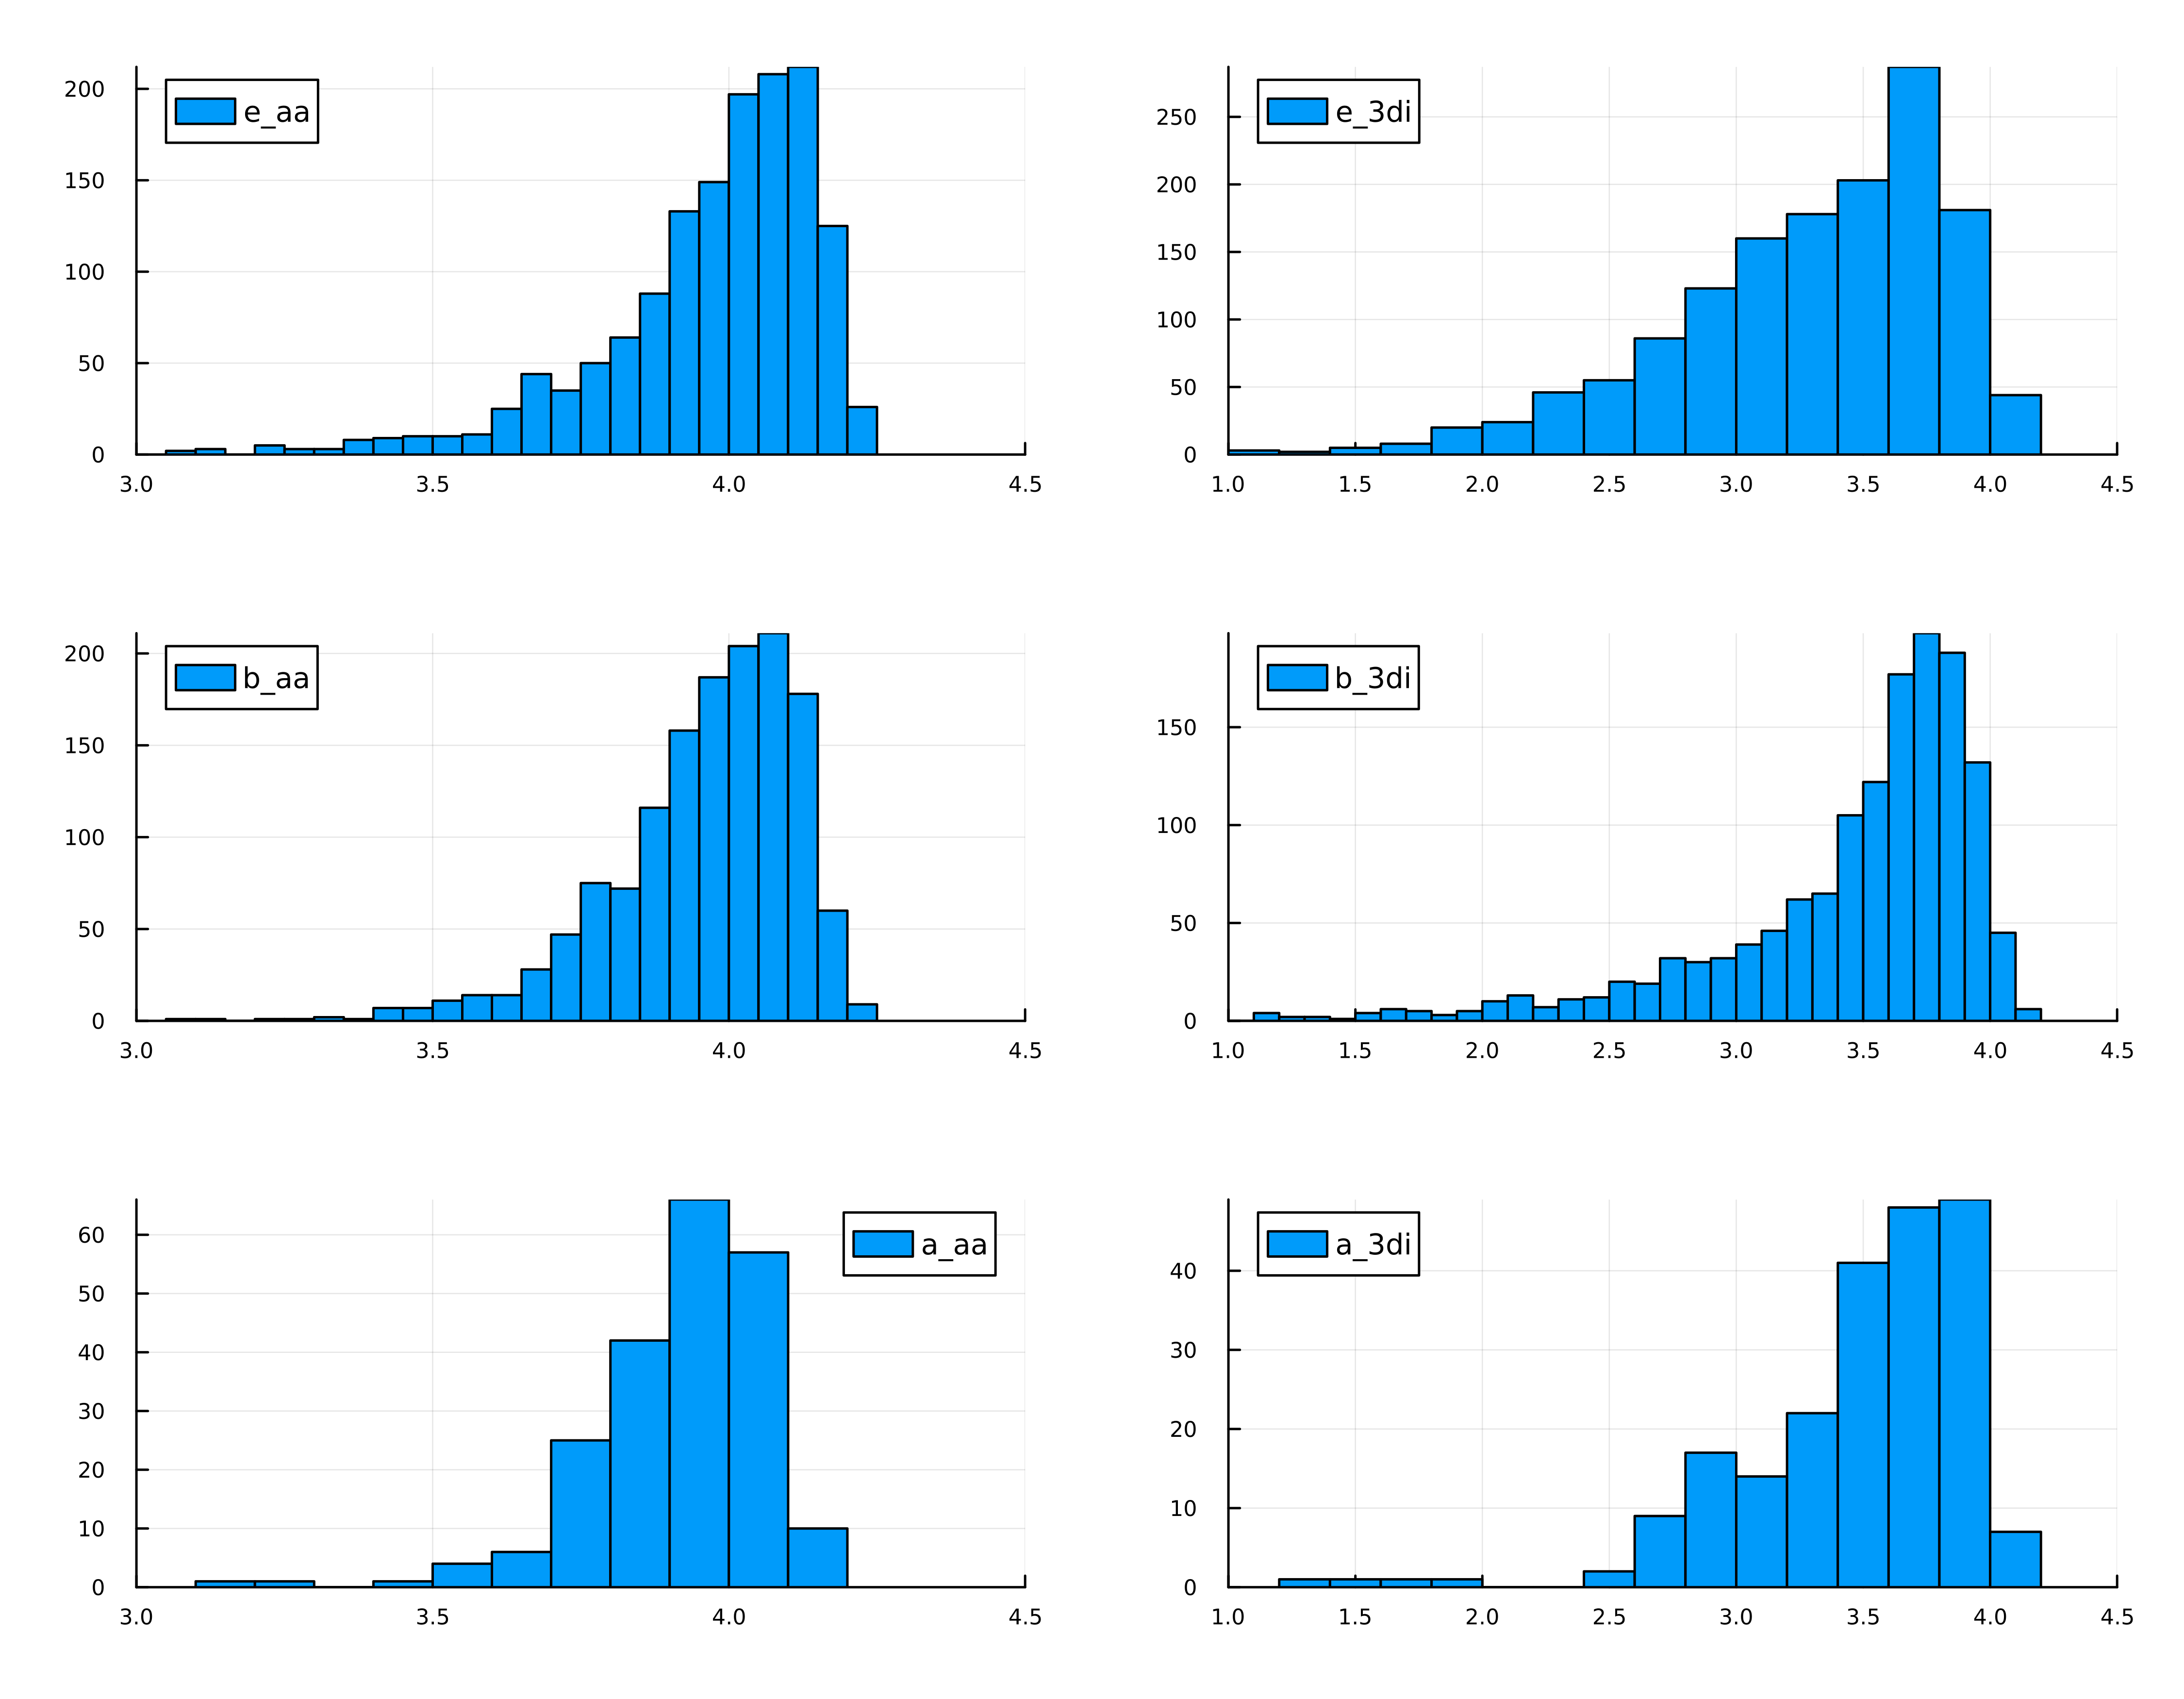

In [247]:
xlim = (3, 4.5)
xlim2 = (1, 4.5)

e_aa = histogram(df[df.domain .== e,:].aaentropy, label="e_aa", xlimits=xlim)
b_aa = histogram(df[df.domain .== b,:].aaentropy, label="b_aa", xlimits=xlim)
#a_aa = histogram(df[df.domain .== a,:].aaentropy, label="a_aa", xlimits=xlim)

e_3di = histogram(df[df.domain .== e,:].seq3dientropy, label="e_3di", xlimits=xlim2)
b_3di = histogram(df[df.domain .== b,:].seq3dientropy, label="b_3di", xlimits=xlim2)
#a_3di = histogram(df[df.domain .== a,:].seq3dientropy, label="a_3di", xlimits=xlim2)


plot(e_aa, e_3di, b_aa, b_3di, a_aa, a_3di, layout=(3, 2), margins = 5mm, dpi=500, xtickfontsize=6, ytickfontsize=6)
plot!(size=(900,700))


In [ ]:
df2 = df[(df.nfrags .> 100) .& (df.nfrags .< 1000),:]
sort!(df2,:aver_rmsd)
df2[end-10:end,:]